# 神经网络剖析
神经网络应该包含以下四个部分：
- 层，也叫做模型
- 输入数据和输出数据
- 损失函数：用于学习参数的时候的返回信号
- 优化器：决定整个学习参数的过程应该如何进行
## 层
不同的数据格式需要不同的层来处理
- 2D张量：常见的就是一些结构化的数据，通过密集连接层，也叫全连接层来处理
- 3D张量：常见的就是一些时序结构的数据，通过循环层，比如说LSTM，来处理
- 4D张量：常见的就是一些图像的数据，通过卷积层，来处理
## 问题
这个章节中主要解决以下三个方面的问题：
- 二分类：电影评价
- 多分类：路透社的文章分类
- 回归分类：房价预测

In [28]:
from keras.datasets import imdb
import warnings
warnings.filterwarnings('ignore')

In [43]:
# 10000的含义是只提取前10000个最常出现的单词，低频次的单词将会被丢弃，保证向量空间不会过大
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [30]:
# 每一个整数代表一个单词，每一个整数的含义是该单词在词汇表中的索引
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [31]:
# 训练数据集中第一个样本，保留了218个单词
len(train_data[0])

218

In [32]:
# 每一个单词的索引都不会超过10000
# 这里应该是把高频词都放在了前面，低频词都放在了后面
# [max(sequence) for sequence in train_data]
max([max(sequence) for sequence in train_data])

9999

In [33]:
# 得到最原始(没有删减之前)的那个字典：词和索引的对应关系
word_index = imdb.get_word_index()
word_index

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

In [34]:
# 原始数据集中大概有9w个单词
len(word_index)

88584

In [35]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# 字典中的前三个单词已经被'padding'、'start'、'unknown'占用了
# 所以字典中的每个索引都往后推迟了三个索引，所以对应的真实字符串要往前找3个，这里就是为什么-3
# 如果在字典里没有找到就返回?
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [37]:
# 看一下还原后的第一个样本
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

In [38]:
print(reverse_word_index.get(1-3, '?'))
print(reverse_word_index.get(14-3, '?'))
print(reverse_word_index.get(22-3, '?'))
print(reverse_word_index.get(16-3, '?'))

?
this
film
was


In [44]:
# 将原始的输入转换成一个长度为10000的稀疏向量
# 最后所有的样本就会形成一个稀疏矩阵
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
train_data = vectorize_sequences(train_data)
test_data = vectorize_sequences(test_data)
train_data[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [45]:
len(train_data[0])

10000

In [48]:
# 先将标签值转换成float32类型，然后再转换成one-hot向量
train_y = np.asarray(train_labels).astype('float32')
test_y = np.asarray(test_labels).astype('float32')

In [50]:
train_y

array([1., 0., 0., ..., 0., 1., 0.], dtype=float32)

In [51]:
# 定义模型
from keras import models, layers
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

2022-04-10 17:14:56.245301: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-10 17:14:56.245353: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-10 17:14:56.245390: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (yy): /proc/driver/nvidia/version does not exist
2022-04-10 17:14:56.246872: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [52]:
# 编译模型
# 是二分类的问题，所以我们使用binary_crossentropy
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [55]:
train_data.shape

(25000, 10000)

In [56]:
test_data.shape

(25000, 10000)

In [57]:
# 将训练数据集划分成两个部分，一部分用来训练，一部分用来验证
x_val = train_data[:10000]
partial_x_train = train_data[10000:]
y_val = train_y[:10000]
partial_y_train = train_y[10000:]

In [58]:
# 训练模型
history = model.fit(partial_x_train,partial_y_train,epochs=20,batch_size=512,validation_data=(x_val,y_val))

Epoch 1/20


2022-04-10 17:21:09.412031: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 600000000 exceeds 10% of free system memory.


29/30 [============================>.] - ETA: 0s - loss: 0.5016 - accuracy: 0.7914

2022-04-10 17:21:12.495814: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 400000000 exceeds 10% of free system memory.


30/30 [==============================] - 3s 76ms/step - loss: 0.5006 - accuracy: 0.7919 - val_loss: 0.3756 - val_accuracy: 0.8711
Epoch 2/20
30/30 [==============================] - 1s 46ms/step - loss: 0.2944 - accuracy: 0.9077 - val_loss: 0.3080 - val_accuracy: 0.8838
Epoch 3/20
30/30 [==============================] - 1s 43ms/step - loss: 0.2155 - accuracy: 0.9317 - val_loss: 0.3095 - val_accuracy: 0.8746
Epoch 4/20
30/30 [==============================] - 1s 45ms/step - loss: 0.1699 - accuracy: 0.9473 - val_loss: 0.2881 - val_accuracy: 0.8840
Epoch 5/20
30/30 [==============================] - 1s 47ms/step - loss: 0.1358 - accuracy: 0.9569 - val_loss: 0.2905 - val_accuracy: 0.8866
Epoch 6/20
30/30 [==============================] - 1s 44ms/step - loss: 0.1131 - accuracy: 0.9657 - val_loss: 0.2953 - val_accuracy: 0.8849
Epoch 7/20
30/30 [==============================] - 1s 45ms/step - loss: 0.0897 - accuracy: 0.9738 - val_loss: 0.3310 - val_accuracy: 0.8822
Epoch 8/20
30/30 [======

In [60]:
# 看一下整个训练过程中发生了什么
# 其中loss是在训练数据集上的损失，accuracy是在训练数据集上的准确率
# val_loss是验证集的损失函数，val_acc是验证集的准确率
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

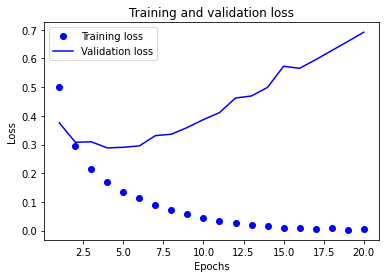

In [61]:
# 将上面的结果做一个可视化的展示，看一下训练数据集上的损失和验证集上的损失
import matplotlib.pyplot as plt
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

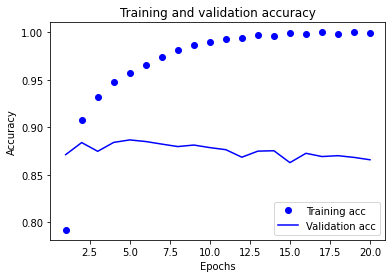

In [63]:
# 绘制训练数据集和验证集上的准确率
plt.clf()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()